This is part of the [geonewb](https://bitsofanalytics.org/posts/geonewb-intro/) series of posts.

In [Part 1](https://bitsofanalytics.org/posts/algaebloom-part1/) of this series we got an overview some of the Python geospatial libraries, created a conda virtual environment and explored the project data associated with the [Detecting harmful algal bloom challenge](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/649/). Now we'll move on in the tutorial to exploring:

- **acquiring satellite image data** (both Sentinel-2 and Landsat) from **Microsoft's Planetary Computer**,
- build a basic understanding of the **structure and data content** of these satellite created images,
- basic **viewing and manipulation of satellite imagery**.

As mentioned in the Part 1, I'm following along and taking some deeper dives and various detours from the official [Getting Started Tutorial](https://drivendata.co/blog/tick-tick-bloom-benchmark).

In this part we'll primarily work with a single image file. In Part 3 we'll tackle the more general problem of programmatically finding images that intersect some point of interest and that were created with a specific data range (as well as doing some basic GeoPandas work).

In subsequent parts we'll tackle the **feature engineering** and **predictive modeling** sections of the original tutorial.



In [1]:
# Need to do some date math and need to work with file paths
from datetime import timedelta
from pathlib import Path

In [2]:
# Big 3 - come on, of course you'll need these
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from IPython.display import Image
from PIL import Image as PILImage

In [4]:
%matplotlib inline

# Finding and acquiring satellite imagery data
Unline many challenges at [DrivenData](https://www.drivendata.org/), the feature data for this challenge is not directly provided. We need to get it using various APIs from specific sources. The date and location for each `uid` in the metadata can be used to find relevant satellite images from a number of different places. There are four approved data sources and all the details are described on the project home page at the following links:

- [Sentinel-2 satellite imagery](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#sentinel-2-1)
- [Landsat satellite imagery](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#landsat-1)
- [NOAA's High-Resolution Rapid Refresh (HRRR) climate data](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#climate-data-1)
- [Copernicus DEM elevation data](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#elevation-data-1)

For now we will just focus on finding relevant Sentinel-2 and Landsat data. This [page in the challenge site](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#satellite-imagery) has additional information and resources related to retrieving satellite imagery data. From that page you can get a very good high level overview of the different *levels* of satellite imagery data, top of atmosphere reflectance vs bottom of atmosphere reflectance, atmospheric corrections, spectral bands and algorithmic bands, as well as the relevant links for accessing data from the MPC.

From the main tutorial:

> The general steps we'll use to pull satellite data are:
>
>    1. Establish a connection to the Planetary Computer's STAC API using the planetary_computer and pystac_client Python packages.
>
>    2. Query the STAC API for scenes that capture our in situ labels. For each sample, we'll search for imagery that includes the sample's location (latitude and longitude) around the date the sample was taken. In this benchmark, we'll use only Sentinel-2 L2A and Landsat Level-2 data.
>
>    3. Select one image for each sample. We'll use Sentinel-2 data wherever it is available, because it is higher resolution. We'll have to use Landsat for data before roughly 2016, because Sentinel-2 was not available yet.
>
>    4. Convert the image to a 1-dimensional list of features that can be input into our tree model

Before trying to grab any data, let's learn a bit more about Sentinel-2.

# Understanding Sentinel-2 imaging data

Start by going to the [Sentinel Mission Overview page](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/overview) and spend some time reading about the mission and the associated data. You can find even more detail in the [Sentinel 2 - User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook).

In [5]:
Image(url='images/sentinel2_overview.png')

After doing a bunch of reading, I still had many questions.

- How do we do basic things like find images (geoTIFF) files and save the image itself to disk?
- What exactly is in this imaging data? There are numerous bands with different types of data and at different resolution levels (size in meters of each cell width).
- How do we read this imaging data into data structures amenable to further analysis?
- What kinds of analysis can we do with this data?
- What existing resources are available for newbies to Sentinel image data analysis?

A good place to start is with the Microsoft's Planetary Computer (MPC) and its Explore feature. We'll use that to find an image of interest and start to figure out how to work with it.

# Walk through for one Sentinel-2 sample from Microsoft's Planetary Computer

The [Planetary Computer](https://planetarycomputer.microsoft.com/docs/overview/about) has a few different pieces:

- [Data Catalog](https://planetarycomputer.microsoft.com/catalog) - It is a ginormous repository of well cataloged data all about Earth's various systems and includes a web based interface that allows users to find relevant data - for free.
- [API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) - It has an API that leverages open source tools to make it easy to do data searches by time and location. Focuses on Python.
- [Hub](https://planetarycomputer.microsoft.com/docs/overview/environment/) - A managed compute environment for doing cloud based geospatial analysis at scale. For this part you need to apply for access.
- [Applications](https://planetarycomputer.microsoft.com/applications) - an ecosystem of people doing meaningful work with the Planetary Computer.

You can manually explore the data catalogs by going to [https://planetarycomputer.microsoft.com/explore](https://planetarycomputer.microsoft.com/explore). You can zoom on the map, specify a dataset collection, do some filtering, and get a list of items. You can view an item's metadata through the online interface, but to get at the actual *assets*, you need to use the [PyStac API](https://pystac.readthedocs.io/en/stable/api.html). For Sentinel data, the assets include the [COGs (cloud optimized GeoTIFF)](https://www.cogeo.org/) associated with each spectral band's reflectance level for each pixel measured by the satellite. There is additional metadata at the item level and the assets level. The actual image related data is stored in Azure blobs and an `href` property is included in each COG. 

First, let's see how to grab a specific item from MPC if you know the item URL. How would you know that? You can use the online MPC catalog explorer to find an item you are interested in and then ask for a code snippet. For example, I zoomed in around the eastern coast of Michigan near Thunder Bay. Then in the left side menu, select the Sentinel-2A catalog, and a list of images was found sorted in decreasing date order - you can also filter by date range. As you scroll through the search results you'll start to get a sense of some of the challenges associated with imagery data - like clouds! 

I picked one from early November, 2022 that looked relatively cloud free. After selecting an image item, you'll be able to click on the squiqqly brackets icon to get a Python code snippet for accessing this item via the PyStac API. Here's the snippet:

In [6]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
asset_href = signed_item.assets["AOT"].href
ds = rioxarray.open_rasterio(asset_href)
ds


<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

There's much to be learned from a careful look at this code. First, the imports.

- `pystac` - we need this work work with MPC's STAC API
- `planetary_computer` - even though MPC allows free access via the STAC API, we need this library in order to *sign* the item we are trying to retrieve. As we'll see later, this results in a long token string getting appended to the item URL. More on signing later.
- `rioxarray` - as we saw in [this section of Part 1](https://bitsofanalytics.org/posts/algaebloom-part1/#rioxarray---read-raster-data-into-xarray-objects), rioxarray is needed to open the actual raster image file and tuck it into an xarray `DataArray`.

Now for the `item_url`. It looks like this:

    https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/
    S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305
    
We see from the URL that:

- we are going to be using the STAC API
- this image is from the Sentinel-2 mission
- this is Level 2A data
- this particular image is one of a larger collection of image items
- the particular image has a unique id of `S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305`

Notice that the *datatake sensing time* (a date and time) are embedded in the `id`. The `id` naming conventions are explained at https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention which also includes links to detailed product specification pages.

The `S2B` is the *mission id* and the `MSIL2A` is:

> MSIL1C denotes the Level-1C product level/ MSIL2A denotes the Level-2A product level

The `R083` is is the *relative orbit number* and the `T16TGQ` is a *tile number field* and the second datetime is:

> The second date is the \<Product Discriminator> field, which is 15 characters in length, and is used to distinguish between different end user products from the same datatake. Depending on the instance, the time in this field can be earlier or slightly later than the datatake sensing time.


Grab the image item and sign it.

```python
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)
```

We are just passing the URL for the item we want and using `pystac` to get it and `planetary_computer` to sign it. If it's not signed, we won't be able to access its details. Let's explore this PyStac `Item` object.

In [7]:
print(signed_item)

<Item id=S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305>


What about the attributes of an `Item`?

In [8]:
[att for att in dir(signed_item) if '__' not in att]

['STAC_OBJECT_TYPE',
 '_abc_impl',
 '_object_links',
 '_repr_html_',
 'add_asset',
 'add_link',
 'add_links',
 'assets',
 'bbox',
 'clear_links',
 'clone',
 'collection_id',
 'common_metadata',
 'datetime',
 'extra_fields',
 'from_dict',
 'from_file',
 'full_copy',
 'geometry',
 'get_assets',
 'get_collection',
 'get_datetime',
 'get_links',
 'get_parent',
 'get_root',
 'get_root_link',
 'get_self_href',
 'get_single_link',
 'get_stac_objects',
 'id',
 'links',
 'make_asset_hrefs_absolute',
 'make_asset_hrefs_relative',
 'matches_object_type',
 'properties',
 'remove_links',
 'resolve_links',
 'save_object',
 'self_href',
 'set_collection',
 'set_datetime',
 'set_parent',
 'set_root',
 'set_self_href',
 'stac_extensions',
 'to_dict',
 'validate']

Let's check out a few basic things.

In [9]:
print(f'The item is id {signed_item.id}')
print(f'The bounding box for this item is {signed_item.bbox}')

The item is id S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305
The bounding box for this item is [-84.50015, 44.09977092, -83.0639, 45.12552488]


In [9]:
signed_item.self_href

'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20221103T163439_R083_T16TGQ_20221104T085305'

In [10]:
signed_item.get_root_link()

<Link rel=root target=https://planetarycomputer.microsoft.com/api/stac/v1/>

In [11]:
signed_item.STAC_OBJECT_TYPE

<STACObjectType.ITEM: 'Feature'>

In [10]:
signed_item.properties

{'datetime': '2022-11-03T16:34:39.024000Z',
 'platform': 'Sentinel-2B',
 'proj:epsg': 32616,
 'instruments': ['msi'],
 's2:mgrs_tile': '16TGQ',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2B_OPER_MSI_L2A_TL_ESRI_20221104T085306_A029567_T16TGQ_N04.00',
 'eo:cloud_cover': 8.857534,
 's2:datatake_id': 'GS2B_20221103T163439_029567_N04.00',
 's2:product_uri': 'S2B_MSIL2A_20221103T163439_N0400_R083_T16TGQ_20221104T085305.SAFE',
 's2:datastrip_id': 'S2B_OPER_MSI_L2A_DS_ESRI_20221104T085306_S20221103T163800_N04.00',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2022-11-04T08:53:05.399641Z',
 'sat:relative_orbit': 83,
 's2:water_percentage': 21.674606,
 's2:mean_solar_zenith': 60.4296636848309,
 's2:mean_solar_azimuth': 169.548110700749,
 's2:processing_baseline': '04.00',
 's2:snow_ice_percentage': 0.000169,
 's2:vegetation_percentage': 35.986048,
 's2:thin_cirrus_percentage': 7.807394,
 's2:cloud_shadow_percen

The `'proj:epsg': 32616` corresponds to the WGS 84 / UTM zone 16N coordinate reference system. See [https://epsg.io/32616](https://epsg.io/32616). The units are in meters. 

The actual data we are after lives in the `assets` dictionary. Before diving in, let's see what assets are available.

In [11]:
for asset_key, asset in signed_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

More about these bands from the original tutorial:

> We have visible bands (red, green, and blue), as well as a number of other spectral ranges and a few algorithmic bands. The Sentinel-2 [mission guide](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data) has more details about what these bands are and how to use them!
>
> A few of the [algorithmic bands](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) that may be useful are:
>
> - [Scene classification (SCL)](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units): The scene classification band sorts pixels into categories including water, high cloud probability, medium > cloud probability, and vegetation. Water pixels could be used to calculate the size of a given water body, which impacts the behavior of  blooms. Vegetation can indicate non-toxic marine life like sea grass that sometimes resembles cyanobacteria.
>

**NOTE** The tutorial then mentions the CLM band, but this no longer seems to exist.

The SLC, AOT (haze), and WVP are considered *Quality Assurance* bands and can be useful in filtering out low quality images. See [https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html)
 for a nice summary of these.

Here are the SCL values (color values from part of the [Google Earth Engine docs](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#image-properties))

        Value 	Color 	Description
        1   	ff0004 	Saturated or defective
        2   	868686 	Dark Area Pixels
        3   	774b0a 	Cloud Shadows
        4   	10d22c 	Vegetation
        5   	ffff52 	Bare Soils
        6   	0000ff 	Water
        7   	818181 	Clouds Low Probability / Unclassified
        8   	c0c0c0 	Clouds Medium Probability
        9   	f1f1f1 	Clouds High Probability
        10  	bac5eb 	Cirrus
        11  	52fff9 	Snow / Ice

As we'll soon see, the `visual` band contains the red, green, and blue bands (not surprising). The `rendered_preview` is a png file. So, that is pretty straightforward to view using `IPython.display.Image`.

In [12]:
Image(url=signed_item.assets['rendered_preview'].href)

## Cropping or clipping the image

Before taking a closer look at the details of specific items in the`assets` dictionary, let's see how we can crop an item asset using a bounding box. Often we'll want to do this because we are interested in some small portion of the overall image. 

The geopy library has a distance related function that we can use to find a bounding box of a specific size. 

In [13]:
import geopy.distance as distance

Here's a short example from the geopy docs.

In [14]:
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)

# Use default geodesic distance
print(f'newport to cleveland (miles): {distance.distance(newport_ri, cleveland_oh).miles}')
print(f'newport to cleveland (km): {distance.distance(newport_ri, cleveland_oh).km}\n')

# Use great_circle distance
print(f'newport to cleveland (miles) using great_circle: {distance.great_circle(newport_ri, cleveland_oh).miles}')
print(f'newport to cleveland (km) using great_circle: {distance.great_circle(newport_ri, cleveland_oh).km}\n')

# Use different elipsiod
print(f'newport to cleveland (miles) ellipsoid=GRS-80: {distance.distance(newport_ri, cleveland_oh, ellipsoid="GRS-80").miles}')
print(f'newport to cleveland (km) ellipsoid=GRS-80: {distance.distance(newport_ri, cleveland_oh, ellipsoid="GRS-80").km}')

newport to cleveland (miles): 538.3904453677203
newport to cleveland (km): 866.4554329098685

newport to cleveland (miles) using great_circle: 536.9979906964344
newport to cleveland (km) using great_circle: 864.2144943393625

newport to cleveland (miles) ellipsoid=GRS-80: 538.3904453716029
newport to cleveland (km) ellipsoid=GRS-80: 866.4554329161169


Let's create a function to make it easy to define a bounding box around a lat, long pair. This code is right from the [algae bloom tutorial](https://drivendata.co/blog/tick-tick-bloom-benchmark).

In [15]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=1000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [16]:
lat = 45.0393354
long = -83.3037169

In [17]:
bbox = get_bounding_box(lat, long, meter_buffer=1000)
bbox

[-83.31640840401764, 45.030337128781625, -83.29102539598236, 45.04833365698021]

We need to pick a specific item asset to crop - let's do the `visual` asset. It's the true color image and contains red, blue and green spectral bands. This is where we need the `rioxarray` library to read in the raster file which is available from MPC using the asset's `href` attribute.

Use `rioxarray.open_rasterio` along with `rio.clip_box` to clip (crop) the image. The `open_rasterio` function is actually wrapping functionality from the [rasterio library]() and `rio` is an *accessor* which let's us get at `rioxarray` functions. Let's just get this working and then we can create a function we can reuse.

For the coordinate reference system we specify `"EPSG:4326"` - the WGS84 standard. Now, I'm a little confused because if you look above at the `signed_item` properties, you'll find `'proj:epsg': 32616,`. EPSG:32616 is a specific UTM zone (16N) within WGS-84. But, if we specify this EPSG code below, we are told that our bbox doesn't intersect the image. Clearly I need to learn more about coordinate reference systems.

In [18]:
# Specify which asset we want
minx, miny, maxx, maxy = bbox
which_asset = 'visual'

image = rioxarray.open_rasterio(signed_item.assets[which_asset].href).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
)

print(f'image data type: {type(image)}')


image data type: <class 'xarray.core.dataarray.DataArray'>


The raster file gets read into a `DataArray` from the xarray package.

In [19]:
image.shape

(3, 210, 210)

The first dimension is color band, the second is height and the third is width.

To get at the actual values we use the `values` property of the image xarray. For assets with multiple bands (such as `visual`), each band has an associated (y, x) matrix.

In [20]:
print(image[0, 100:115, 100:105].values)

[[115 124 128 134 133]
 [120 131 129 129 133]
 [129 136 131 129 128]
 [140 137 135 135 131]
 [109 124 138 140 138]
 [ 50  75 112 128 122]
 [ 36  38  61  75  71]
 [ 52  48  49  36  34]
 [ 58  59  52  42  48]
 [ 57  59  50  49  54]
 [ 43  43  53  53  53]
 [ 47  40  53  51  46]
 [ 42  39  43  41  37]
 [ 38  37  32  29  30]
 [ 43  40  31  27  26]]


The values in the `visual` band are scaled on a 0-255 scale. If you look at some of the other bands, the values are NOT scaled. More on that later.

Let's wrap this in a function. We'll make sure we are opening a signed item by using `planetary_computer.sign`.

In [21]:
def crop_sentinel_image(item, bounding_box, asset_str):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    cropped_image = rioxarray.open_rasterio(planetary_computer.sign(item.assets[asset_str].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return cropped_image

Now we'll crop the image, returning a `DataArray`, and create a numpy array from that. Then we can view the image by plotting the numpy array with matplotlib.

In [22]:
# Crop the image
cropped_img = crop_sentinel_image(item, bbox, 'visual')
print(f'cropped_image is a {type(cropped_img)} with dimensions of {cropped_img.dims} and shape = {cropped_img.shape}')

# Create a numpy array from the cropped image
cropped_img_array = cropped_img.to_numpy()
print(f'cropped_image_array is a {type(cropped_img_array)} with shape = {cropped_img_array.shape}')

cropped_image is a <class 'xarray.core.dataarray.DataArray'> with dimensions of ('band', 'y', 'x') and shape = (3, 210, 210)
cropped_image_array is a <class 'numpy.ndarray'> with shape = (3, 210, 210)


You can see how the xarray package adds dimension names to numpy arrays.

We have to transpose some of the dimensions to plot since matplotlib expects channels in a certain order (y, x, band). Note that the band dimension is of length 3 - red, green and blue.

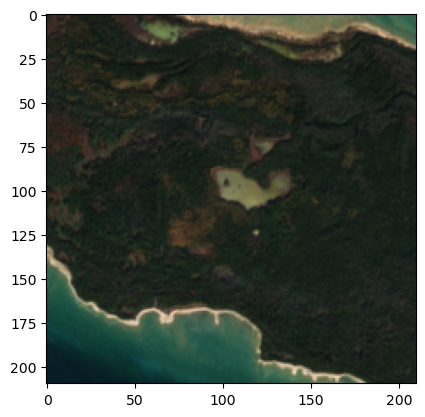

In [23]:
plt.imshow(np.transpose(cropped_img_array, axes=[1, 2, 0]))

One last detour before looking a little closer at the `assets` dictionary - downloading and saving one of these GeoTIFF files on a local machine. While it's great that all the images are always available from the cloud that is the MPC, sometimes we want to have a few local images to play around with during our learning.

## Downloading and saving a Sentinel-2 image on local machine

The following tutorial walks through the steps of finding, exploring, saving local, and processing local of an image file from MPC.

- [Introduce a Notebook gallery image to process Geospatial data from Planetary Computer with STAC API](https://techcommunity.microsoft.com/t5/azure-synapse-analytics-blog/introduce-a-notebook-gallery-image-to-process-geospatial-data/ba-p/3582865)

We are simply using the `requests` library to grab the image using a signed item's `href` property and then writing it as a binary file to our local filesystem.

In [24]:
import requests

In [25]:
signed_href = signed_item.assets['visual'].href

We'll keep the original filename and we can extract it from the URL by splitting on the `'?'` and then using Pathlib's `name` attribute.

In [26]:
base_url = signed_item.assets['visual'].href.split('?')[0]
print(base_url)
filename = Path(base_url).name
print(filename)

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/GQ/2022/11/03/S2B_MSIL2A_20221103T163439_N0400_R083_T16TGQ_20221104T085305.SAFE/GRANULE/L2A_T16TGQ_A029567_20221103T163800/IMG_DATA/R10m/T16TGQ_20221103T163439_TCI_10m.tif
T16TGQ_20221103T163439_TCI_10m.tif


Ok, let's save it in the `images/` subfolder.


In [27]:
# use requests to grab the file and write it out

redownload = False # Avoiding redownloading

if redownload:
    response = requests.get(signed_href)
    with open(Path('images', filename), "wb") as f:
        f.write(response.content)

Great, we can save a file locally if we want. Here's an overly verbose functionized version. We'll use it later to download one of the other image bands.

In [28]:
def download_tif_from_mpc(item, which_asset, dest_folder):
    signed_href = pc.sign(item).assets[which_asset].href
    base_url = signed_href.split('?')[0]
    filename = Path(base_url).name
    save_path = Path(dest_folder, filename)
    response = requests.get(signed_href)
    with open(save_path, "wb") as f:
        f.write(response.content)

One reason that I wanted to have a few local TIFF files was so that I could explore and mess around with them in [QGIS](https://www.qgis.org/en/site/), a terrific free and open source desktop GIS package. There are tons of tutorials, it's easy to use, has a vibrant user community and numerous specialized tools (both built in and via plug-ins). You can even do things like launch GDAL commands from a GUI and then see the corresponding command line code. Here's a screenshot of the TIFF file we just downloaded. You can see the individual RGB bands on the Layers area.

<div>
<img src="images/thunder_bay_qgis.png" width="500"/>
</div>


## Exploring the `assets` of our STAC item

The dictionary keys are one of the values that we saw earlier (e.g. `B01`, `B02`, ...) and the values`Asset` objects and that have an `href` attribute that points to where the asset is stored in MPC. If you look at the URLs, you can see the appended tokens indicating that the item has been signed. For example (it's wide, you'll need to scroll):

```python
{'AOT': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/GQ/2022/11/03/S2B_MSIL2A_20221103T163439_N0400_R083_T16TGQ_20221104T085305.SAFE/GRANULE/L2A_T16TGQ_A029567_20221103T163800/IMG_DATA/R10m/T16TGQ_20221103T163439_AOT_10m.tif?st=2023-01-27T22%3A47%3A33Z&se=2023-01-28T23%3A32%3A33Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-28T21%3A28%3A38Z&ske=2023-02-04T21%3A28%3A38Z&sks=b&skv=2021-06-08&sig=ZrRJpxPGmswyY7GH3HlNiuFKJPR5VA4hbne4gbDoUR0%3D>,
 'B01': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/GQ/2022/11/03/S2B_MSIL2A_20221103T163439_N0400_R083_T16TGQ_20221104T085305.SAFE/GRANULE/L2A_T16TGQ_A029567_20221103T163800/IMG_DATA/R60m/T16TGQ_20221103T163439_B01_60m.tif?st=2023-01-27T22%3A47%3A33Z&se=2023-01-28T23%3A32%3A33Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-28T21%3A28%3A38Z&ske=2023-02-04T21%3A28%3A38Z&sks=b&skv=2021-06-08&sig=ZrRJpxPGmswyY7GH3HlNiuFKJPR5VA4hbne4gbDoUR0%3D>,
... 
```


You'll also see that the bands are
[TIFF files](https://en.wikipedia.org/wiki/TIFF) (actually [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) files) - they have a `.tif` extension. TIFF files are commonly used for storing raster data and can included tagged metadata and even multiple "images" within one file. The GeoTIFF standard allows georeferencing info to be included as tagged metadata in a TIFF file. There are also some XML assets that appear to be metadata related.

The STAC spec can be found at [https://github.com/radiantearth/stac-spec](https://github.com/radiantearth/stac-spec). 



Let's examine the `'B08'` asset - [the NIR (near infrared) spectral band](https://en.wikipedia.org/wiki/Infrared).

In [30]:
nir_asset = signed_item.assets['B08']
[att for att in dir(nir_asset) if '__' not in att]

['_repr_html_',
 'clone',
 'common_metadata',
 'description',
 'extra_fields',
 'from_dict',
 'get_absolute_href',
 'href',
 'media_type',
 'owner',
 'roles',
 'set_owner',
 'title',
 'to_dict']

The `to_dict` method will give use details about the band.

In [31]:
nir_asset.to_dict()

{'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/GQ/2022/11/03/S2B_MSIL2A_20221103T163439_N0400_R083_T16TGQ_20221104T085305.SAFE/GRANULE/L2A_T16TGQ_A029567_20221103T163800/IMG_DATA/R10m/T16TGQ_20221103T163439_B08_10m.tif?st=2023-01-27T22%3A47%3A33Z&se=2023-01-28T23%3A32%3A33Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-28T21%3A28%3A38Z&ske=2023-02-04T21%3A28%3A38Z&sks=b&skv=2021-06-08&sig=ZrRJpxPGmswyY7GH3HlNiuFKJPR5VA4hbne4gbDoUR0%3D',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'title': 'Band 8 - NIR - 10m',
 'proj:bbox': [699960.0, 4890240.0, 809760.0, 5000040.0],
 'proj:shape': [10980, 10980],
 'proj:transform': [10.0, 0.0, 699960.0, 0.0, -10.0, 5000040.0],
 'gsd': 10.0,
 'eo:bands': [{'name': 'B08',
   'common_name': 'nir',
   'description': 'Band 8 - NIR',
   'center_wavelength': 0.842,
   'full_width_half_max': 0.145}],
 'roles': ['data']}

In [32]:
[key for key in nir_asset.to_dict()]

['href',
 'type',
 'title',
 'proj:bbox',
 'proj:shape',
 'proj:transform',
 'gsd',
 'eo:bands',
 'roles']

What are these? 

The first three are general information about the item band.

- `href` - URL for the data in Azure blob storage
- `type` - the image is a [COG, or cloud-optimized GeoTIFF](https://www.cogeo.org/)
- `title` - it's Band 8, NIR and it's at 10m resolution

Next are three projection related properties and are part of the STAC extensions ecosystem. See [the STAC Extensions repo](https://github.com/stac-extensions/projection) for more details.

- `proj:bbox` - bounding box of the asset CRS (WGS84/UTM zone 16N)

The bbox `[699960.0, 4890240.0, 809760.0, 5000040.0]` corresponds to [min x, min y, max x, max y] ([west, south, east, north])  where `x` is the easting and `y` is the northing in UTM zone 16N. The first two coordinates specify the lower left of the bbox and the last two, the upper right. The center coordinates of UTM zone 16N are (500000.0, 4649776.22). All [UTM zones](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) are centered longitudinally at 500000 to prevent negative eastings. So, the bbox for this image is in the upper right (NE) part of the zone, relative to its center coordinates.

- `proj:shape` - number of rows and columns in the raster image (i.e., in Y, X order)
- `proj:transform` - this is a linear mapping from pixel coordinate space to projection coodinate space. In other words, this mapping is used to map a specific pixel to a spot on the earth using the projected coordinate system we are using. See [https://github.com/stac-extensions/projection#projtransform](https://github.com/stac-extensions/projection#projtransform) for details. The numbers are actually the first two rows of a certain 3x3 matrix used to do the affine transformation.

Next is the `gsd` - *Ground Sample Distance* (or resolution) in the base units of the projected coordinate reference system.

The electro-optical bands property `eo:bands` propery gives more details about this specific spectral band - see [https://github.com/stac-extensions/eo](https://github.com/stac-extensions/eo). Finally, the `roles` property gives us a sense of how we use might this item asset. Besides, `data`, other common roles are `thumbnail`, `overview`, and `metadata`. See [https://github.com/radiantearth/stac-spec/blob/v1.0.0/item-spec/item-spec.md#asset-roles](https://github.com/radiantearth/stac-spec/blob/v1.0.0/item-spec/item-spec.md#asset-roles). for more details.



Now we'll crop the `B08` band using the same bbox we've been using. After cropping we'll look at the raw data values as well as preview the image. Remember, we are using rioxarray to read the TIFF file into an xarray `DataArray`. 

In [33]:
# Crop the image
cropped_B08_img = crop_sentinel_image(signed_item, bbox, 'B08')
print(f'cropped_image is a {type(cropped_img)} with dimensions of {cropped_img.dims} and shape = {cropped_img.shape}')

# Create a numpy array from the cropped image
cropped_B08_img_array = cropped_B08_img.to_numpy()
print(f'cropped_image_array is a {type(cropped_B08_img_array)} with shape = {cropped_B08_img.shape}')

cropped_image is a <class 'xarray.core.dataarray.DataArray'> with dimensions of ('band', 'y', 'x') and shape = (3, 210, 210)
cropped_image_array is a <class 'numpy.ndarray'> with shape = (1, 210, 210)


Let's plot it. 

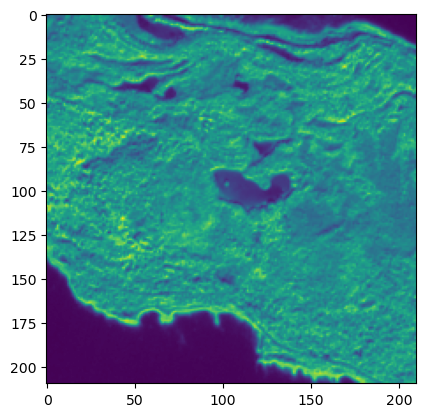

In [34]:
plt.imshow(np.transpose(cropped_B08_img_array, axes=[1, 2, 0]))

To see the actual underlying data values, we again use the `values` property `DataArray` object.

In [35]:
print(cropped_B08_img[0, 100:115, 100:105].values)

[[1830 1852 1842 1907 1822]
 [1973 1890 1874 1878 1862]
 [2174 2014 1958 1906 1874]
 [2394 2190 2070 1979 1932]
 [2218 2212 2190 2108 2011]
 [1880 2024 2110 2296 2106]
 [2354 2100 1860 1903 1710]
 [3034 2852 2510 2076 1886]
 [3408 3308 2936 2652 2652]
 [3382 3144 3100 3188 3146]
 [2776 2598 2760 3166 3210]
 [2548 2550 2714 2826 2646]
 [2592 2598 2584 2670 2620]
 [2456 2432 2494 2660 2644]
 [2620 2656 2670 2770 2804]]


Obviously, unlike the RGB bands, these are NOT on a 0-255 scale. What are they? They are *surface reflectance values* and have been scaled to be integers between 1 and 10000 with 0 being the "nodata" value (different bands will have different unscaled ranges of values). They are considered *Analysis Ready Data* and have been produced after atmospheric corrections have been applied to the raw data from the satellite sensors. The combination of atomosphic corrections and the common scale make it easier to use spectral data in machine learning models.

Here are some good resources for digger deeper into Sentinel data and reflectance values:

- [Sentinel-2 Level-2A Surface Reflectance](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html)
- [Sentinel-2 MSI Technical Guide](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi)
- [Level-2A Algorithm Overview](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)
- [Image conversion to reflectance](https://semiautomaticclassificationmanual-v5.readthedocs.io/en/latest/remote_sensing.html#image-conversion-to-reflectance)

## A good place to stop for part 2

In this part we:

- Used the MPC explorer to find an image item (a COG)
- Used the STAC API to access the image and used rioxarray to load it into a `DataArray` (from xarray package)
- Learned how to download a Sentinel-2 image item
- Explored the structure of a Sentinel-2 item
- Used geopy to create a bounding box
- Cropped an image with a bounding box and rioxarray
- Dug into the spectral band data that can be found in the item assets collection
- Viewed images with matplotlib

In the next part, we'll use Python to find a bunch of images that intersect a point of interest and that were created during a specific data range. We'll also see how the GeoPandas package can be used for working with multiple image items in a query-like way.
